In [1]:
from math import log2
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torch.utils.tensorboard import SummaryWriter  # print to tensorboard
from torch.utils.data import DataLoader
from pathlib import Path
import matplotlib.pyplot as plt
import datetime
import re
import argparse
import numpy as np


from src.models.utils.create_batch import EarthDataTrain
from src.models.model.model import Generator, Discriminator, init_weights
from src.models.loss.wasserstein import gradient_penalty


In [2]:
# for local compute
root_dir = Path.cwd().parent.parent  # set the root directory as a Pathlib path
print(root_dir)

path_prev_checkpoint = root_dir / "models/interim/checkpoints/2021_07_16_203548/train_20.pt" 

path_processed_data = root_dir / "data/processed"
path_input_folder = path_processed_data / "input"
path_truth_folder = path_processed_data / "truth"

/home/tim/Documents/earth-mantle-surrogate


In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

cuda


In [4]:
gen = Generator(
    in_chan=4,
    out_chan=4,
    scale_factor=8,
    chan_base=64,
    chan_min=64,
    chan_max=128,
    cat_noise=True,
).to(device)

In [5]:
checkpoint = torch.load(path_prev_checkpoint)
# epoch_start = checkpoint['epoch']+1
gen.load_state_dict(checkpoint['gen'])
# critic.load_state_dict(checkpoint['critic'])
# opt_gen.load_state_dict(checkpoint['opt_gen'])
# opt_critic.load_state_dict(checkpoint['opt_critic'])

<All keys matched successfully>

In [38]:
earth_dataset = EarthDataTrain(path_input_folder, path_truth_folder, random_roll=False)

In [39]:
loader = DataLoader(
    earth_dataset,
    batch_size=1,
    shuffle=False,
)

In [40]:
for i, data in enumerate(loader):
    x_truth = data["truth"].to(device)
    x_up = data["upsampled"].to(device)
    x_input = data["input"].to(device)

In [41]:
x_input.shape

torch.Size([1, 4, 30, 20, 10])

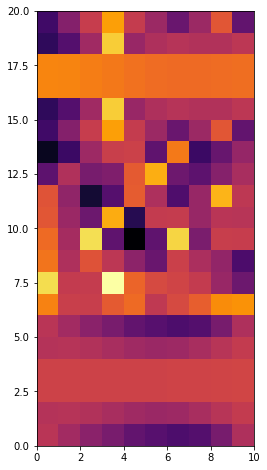

In [42]:
color_scheme='inferno'
fig, ax = plt.subplots(1,1, figsize=(18,8))
ax.pcolormesh(x_input[0,0,0,:,:].cpu(), cmap=color_scheme)
ax.set_aspect(1)

In [43]:
with torch.no_grad():
    gen.eval()
    x_fake = gen(x_input)

In [44]:
x_fake.shape

torch.Size([1, 4, 198, 118, 38])

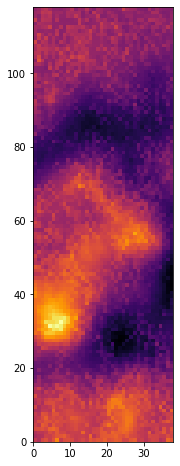

In [45]:
color_scheme='inferno'
fig, ax = plt.subplots(1,1, figsize=(18,8))
ax.pcolormesh(x_fake[0,0,90,:,:].cpu(), cmap=color_scheme)
ax.set_aspect(1)

In [46]:
def pad_data(x, pad_top_bot=0, pad_sides=0):
    "pad top/bot or sides of tensor"
    if pad_sides > 0:
        x = torch.cat((x[:,:,:,:,-pad_sides:], x, x[:,:,:,:,:pad_sides]), axis=-1)

    if pad_top_bot > 0:
        x = torch.cat((torch.flip(x, [3])[:,:,:,-pad_top_bot:,:], # mirror array and select top rows
                         x, 
                         torch.flip(x, [3])[:,:,:,:pad_top_bot,:]), # mirror array and select bottom rows
                      axis=-2) # append along longitudinal (left-right) axis   
    return x

def crop_data(x, crop_height=1, crop_width=1,):
    "symetrically crop tensor"
    w = crop_width
    h = crop_height

    if crop_width == 0 and crop_height == 0:
        return x
    elif crop_width == 0:
        return x[:,:,:,h:-h,:]
    elif crop_height == 0:
        return x[:,:,:,:,w:-w]
    else:
        return x[:,:,:,h:-h,w:-w]

torch.Size([1, 4, 198, 14, 27])


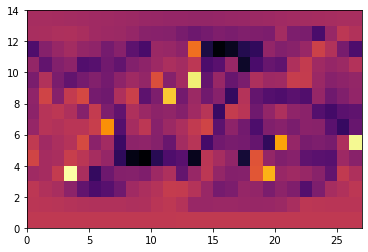

In [49]:
input_data = torch.tensor(np.load(path_input_folder / 'x_001.npy'))
print(input_data.shape)
plt.pcolormesh(input_data[0,0,90,:,:], cmap='inferno')

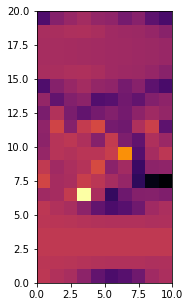

In [50]:
input_data = input_data[:,:,:,:,:10] # select first N points for width
input_data = pad_data(input_data, pad_top_bot=3, pad_sides=0) # hardcoded -- could make flexible in future
fig, ax = plt.subplots(1,1, figsize=(5,5))
ax.pcolormesh(input_data[0,0,90,:,:], cmap='inferno')
ax.set_aspect(1)

In [ ]:
def gen_output_slice_for_concatenate(x_input, gen, roll_increment=0, width=32):
  """
    Args:
        x_input (tensor): Input (downsampled) sample.
        gen (pytorch model): Loaded pytorch model
        roll_increment (int): Amount to roll the input by. Standard x_input has width of 27
    """
    x_input = torch.roll(x_input, roll_increment, 4) # roll if used
    x_input = x_input[:,:,:,:,:10] # select first 10 points for width
    x_input = pad_data(x_input, pad_top_bot=3, pad_sides=0) # pad top/bottom

    with torch.no_grad():
        gen.eval()
        x_fake = gen(x_input)
        
        # x_fake shape: (1, 4, 198, 118, 38)
        return x_fake[:,:,:,:,3:width+3].detach().cpu()
